In [212]:
import os, json, tqdm, time, sys
sys.path.append('../')
from umap import UMAP
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from src.model.modules import SingleEncoderModel
from src.utils.visualization import plot_scatter

## generate data over chemical space

- dataframe

In [52]:
df = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_221123.csv')
col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']
#df = df[~df['TG'].isna()]
wdf = df[col_w].fillna(0)
wmasks = []
for x in 'ABCDE':
    wmasks.append(df.loc[wdf[f'FR_{x}'] == 0, 'ID'].values)
    print(x, len(wmasks[-1]))
    
smiles_e = df.SMILES_E[df.FR_E != 0]
for s in smiles_e.drop_duplicates():
    for x in 'ABCDE':
        m = df[f'FR_{x}'] != 0
        print(x, s, np.sum(df.loc[m, f'SMILES_{x}'] == s))

smiles_all = np.sort(np.unique(df[col_s].values.reshape(-1)))
smiles_f = [s for s in smiles_all if 'F' in s]
smiles_ue = smiles_e.drop_duplicates().values
smiles_c = [s for s in smiles_all if 'F' not in s and s not in smiles_ue]

A 61
B 88
C 106
D 161
E 38
A CC(=C)C(=O)OCCO 0
B CC(=C)C(=O)OCCO 0
C CC(=C)C(=O)OCCO 0
D CC(=C)C(=O)OCCO 0
E CC(=C)C(=O)OCCO 282
A OCCOC(=O)C=C 0
B OCCOC(=O)C=C 0
C OCCOC(=O)C=C 0
D OCCOC(=O)C=C 0
E OCCOC(=O)C=C 7
A CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
B CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 4
C CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
D CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 0
E CC(=C)C(=O)OC12CC3CC(C1)CC(C3)(C2)O 35


- test iteration

In [15]:
interval = 2
e = 2
for a in range(interval, 10-e+interval, interval):
    k = 10 - a - e
    for b in range(interval, k+1, interval):
        for c in range(interval, k-b, interval):
            d = k-b-c
            print('{} | {}  {}  {} | {}  / {}'.format(a, b, c, d, e, a+b+c+d+e))
            
    print('-'*20)
    zerocase = [np.array(l.replace('0_','').split('_'), dtype=int) for l in np.unique(['{}_{}'.format(*sorted((x, y))) for x in range(0, k+1, interval) for y in range(0, k+1, interval) if x+y == k])]
    for zc in zerocase:
        if len(zc) == 1:
            b = zc[0]
            c, d = 0, 0
            print('{} | {}  {}  {} | {}  / {}'.format(a, b, c, d, e, a+b+c+d+e))
        else:
            b, c = zc
            d = 0
            print('{} | {}  {}  {} | {}  / {}'.format(a, b, c, d, e, a+b+c+d+e))
    print('='*20)



2 | 2  2  2 | 2  / 10
--------------------
2 | 6  0  0 | 2  / 10
2 | 2  4  0 | 2  / 10
--------------------
4 | 4  0  0 | 2  / 10
4 | 2  2  0 | 2  / 10
--------------------
6 | 2  0  0 | 2  / 10
--------------------
8 | 0  0  0 | 2  / 10


- generate

In [57]:
pbar = tqdm.tqdm(total=len(smiles_f))
data = {'SMILES_A':[], 'SMILES_B':[], 'SMILES_C':[], 'SMILES_D':[], 'FR_A':[], 'FR_B':[], 'FR_C':[], 'FR_D':[]}
def append_data(data, sa, fra, sb='', frb=0, sc='', frc=0, sd='', frd=0):
    data['SMILES_A'].append(sa)
    data['FR_A'].append(fra)
    data['SMILES_B'].append(sb)
    data['FR_B'].append(frb)
    data['SMILES_C'].append(sc)
    data['FR_C'].append(frc)
    data['SMILES_D'].append(sd)
    data['FR_D'].append(frd)
    return data

interval = 2
e = 2
n = 0
nc = len(smiles_c)

for ia, sa in enumerate(smiles_f):
    data = append_data(data, sa, 1 - e/10)
    pbar.update(1)
    for a in range(interval, 10-e+interval, interval):
        k = 10 - a - e
        for b in range(interval, k+1, interval):
            for ib in range(nc):
                for c in range(interval, k-b, interval):
                    d = k - b - c
                    for ic in range(ib+1, nc):
                        for id in range(ic+1, nc):
                            data = append_data(data, sa, a/10, smiles_c[ib], b/10, smiles_c[ic], c/10, smiles_c[id], d/10)
        zerocase = [np.array(l.replace('0_','').split('_'), dtype=int) for l in np.unique(['{}_{}'.format(*sorted((x, y))) for x in range(0, k+1, interval) for y in range(0, k+1, interval) if x+y == k])]
        for zc in zerocase:
            for ib in range(nc):
                if len(zc) == 1:
                    data = append_data(data, sa, a/10, smiles_c[ib], zc[0]/10)
                else:
                    for ic in range(nc):
                        if ib == ic: continue
                        if zc[0] == zc[1] and ib > ic: continue
                        data = append_data(data, sa, a/10, smiles_c[ib], zc[0]/10, smiles_c[ic], zc[1]/10)
df2 = pd.DataFrame(data)
df2['SMILES_E'] = smiles_ue[0]
df2['FR_E'] = 0.2
df2['ID'] = df2.index
df2 = df2[['ID'] + [f'SMILES_{x}' for x in 'ABCDE'] + [f'FR_{x}' for x in 'ABCDE']]
#df2.to_csv('./data/chem_20231108_0.2.csv', index=False)

100%|██████████| 22/22 [00:35<00:00,  1.62s/it]


In [585]:
dfs = pd.read_csv('./data/chem_20230803_0.2.csv')
dfs.shape[0]

9880.0

In [578]:
col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_f = [f'FR_{x}' for x in 'ABCDE']
smiles_all_s = np.unique(dfs[col_s].fillna('').values)

In [581]:
smiles_all.shape, smiles_all_s.shape
np.array([s for s in smiles_all_s if 'F' in s])

(22,)

# screening

In [18]:

import torch, gc, os, json, pickle, tqdm, time, sys
sys.path.append('../')
from src.model.modules import SingleEncoderModel
from src.utils.dataset import FPolyDatasetV2, collate_fn
from src.utils.data import CrossValidation, DataScaler
from src.utils.trainer import Trainer
from src.utils.visualization import plot_scatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

device = 'cuda'
sdf = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/chem_20231108_0.2.csv')
sdf.shape

(201850, 11)

### by embedding vectors - exploring unknown data

- get data

In [19]:
sdf = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/chem_20231108_0.2.csv')
device = 'cpu'
train_data = FPolyDatasetV2()
test_data = FPolyDatasetV2()
screen_data = FPolyDatasetV2()
train_data.generate(path='/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv', col_smiles=[f'SMILES_{x}' for x in 'ABCDE'],
                    col_weights=[f'FR_{x}' for x in 'ABCDE'], col_target='TG')
test_data.generate(path='/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv', col_smiles=[f'SMILES_{x}' for x in 'ABCDE'],
                   col_weights=[f'FR_{x}' for x in 'ABCDE'], col_target='TG')
screen_data.generate(path='/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/chem_20231108_0.2.csv', col_smiles=[f'SMILES_{x}' for x in 'ABCDE'],
                    col_weights=[f'FR_{x}' for x in 'ABCDE'], col_target='ID')

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : 

- get embedding

In [20]:
train_feat, train_target, _ = collate_fn(train_data, device=device)
test_feat, test_target, _ = collate_fn(test_data, device=device)
train_target = train_target.cpu().numpy().squeeze()
test_target = test_target.cpu().numpy().squeeze()

dls = {
    'train' : DataLoader(train_data, batch_size=4096, collate_fn=collate_fn),
    'test'  : DataLoader(test_data, batch_size=4096, collate_fn=collate_fn),
    'screen': DataLoader(screen_data, batch_size=4096, collate_fn=collate_fn),
}
train_data.to(device)
test_data.to(device)
screen_data.to(device)

if os.path.isfile('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/embedding_data_231108.pkl'):
    with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/embedding_data_231108.pkl','rb') as f:
        preds, embeds = pickle.load(f)
else:
    preds  = {i:{dl_name:[] for dl_name in dls.keys()} for i in range(5)}
    embeds = {i:{dl_name:[] for dl_name in dls.keys()} for i in range(5)}
    scaler = DataScaler(device)
    for i in range(5):
        path = '../outputs/models/finetune/all_ens'
        model = SingleEncoderModel(**json.load(open(os.path.join(path, f'fold_{i}_param.json'))))
        model.load(os.path.join(path, f'fold_{i}_model.torch'), rebuild_model=True)
        model.eval()
        model.to(device)
        scaler.load(path)
        tr = Trainer(model, None, scaler=scaler)
        with torch.no_grad():
            for dl_name, dl in dls.items():
                for batch in dl:
                    p = model(batch[0])
                    e = model._embd
                    preds[i][dl_name].append(scaler.restore(p).cpu().numpy().astype(float))
                    embeds[i][dl_name].append(e.cpu().numpy().astype(float))
                preds[i][dl_name] = np.vstack(preds[i][dl_name]).squeeze()
                embeds[i][dl_name] = np.vstack(embeds[i][dl_name]).squeeze()
        with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/embedding_data_231108.pkl','wb') as f:
            pickle.dump([preds, embeds], f)

- get manifold

In [22]:
n1, n2, n3 = [v.shape[0] for v in embeds[0].values()]
n2 = n1 + n2
if os.path.isfile('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/tvecs_231108.pkl'):
    with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/tvecs_231108.pkl','rb') as f:
        tvecs = pickle.load(f)
else:
    tvecs = {}
#    for i in range(5):
#        tsne = TSNE(random_state=100)
#        tvecs[i] = tsne.fit_transform(np.vstack([e for e in embeds[i].values()]))
    tsne = TSNE(random_state=10)    
    tvecs['a'] = tsne.fit_transform(np.hstack([np.vstack([e for e in embeds[i].values()]) for i in range(5)]))
    with open('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/tvecs_231108.pkl','wb') as f:
        pickle.dump(tvecs, f)

- plot with predicted temperature

(-150.0, 150.0)

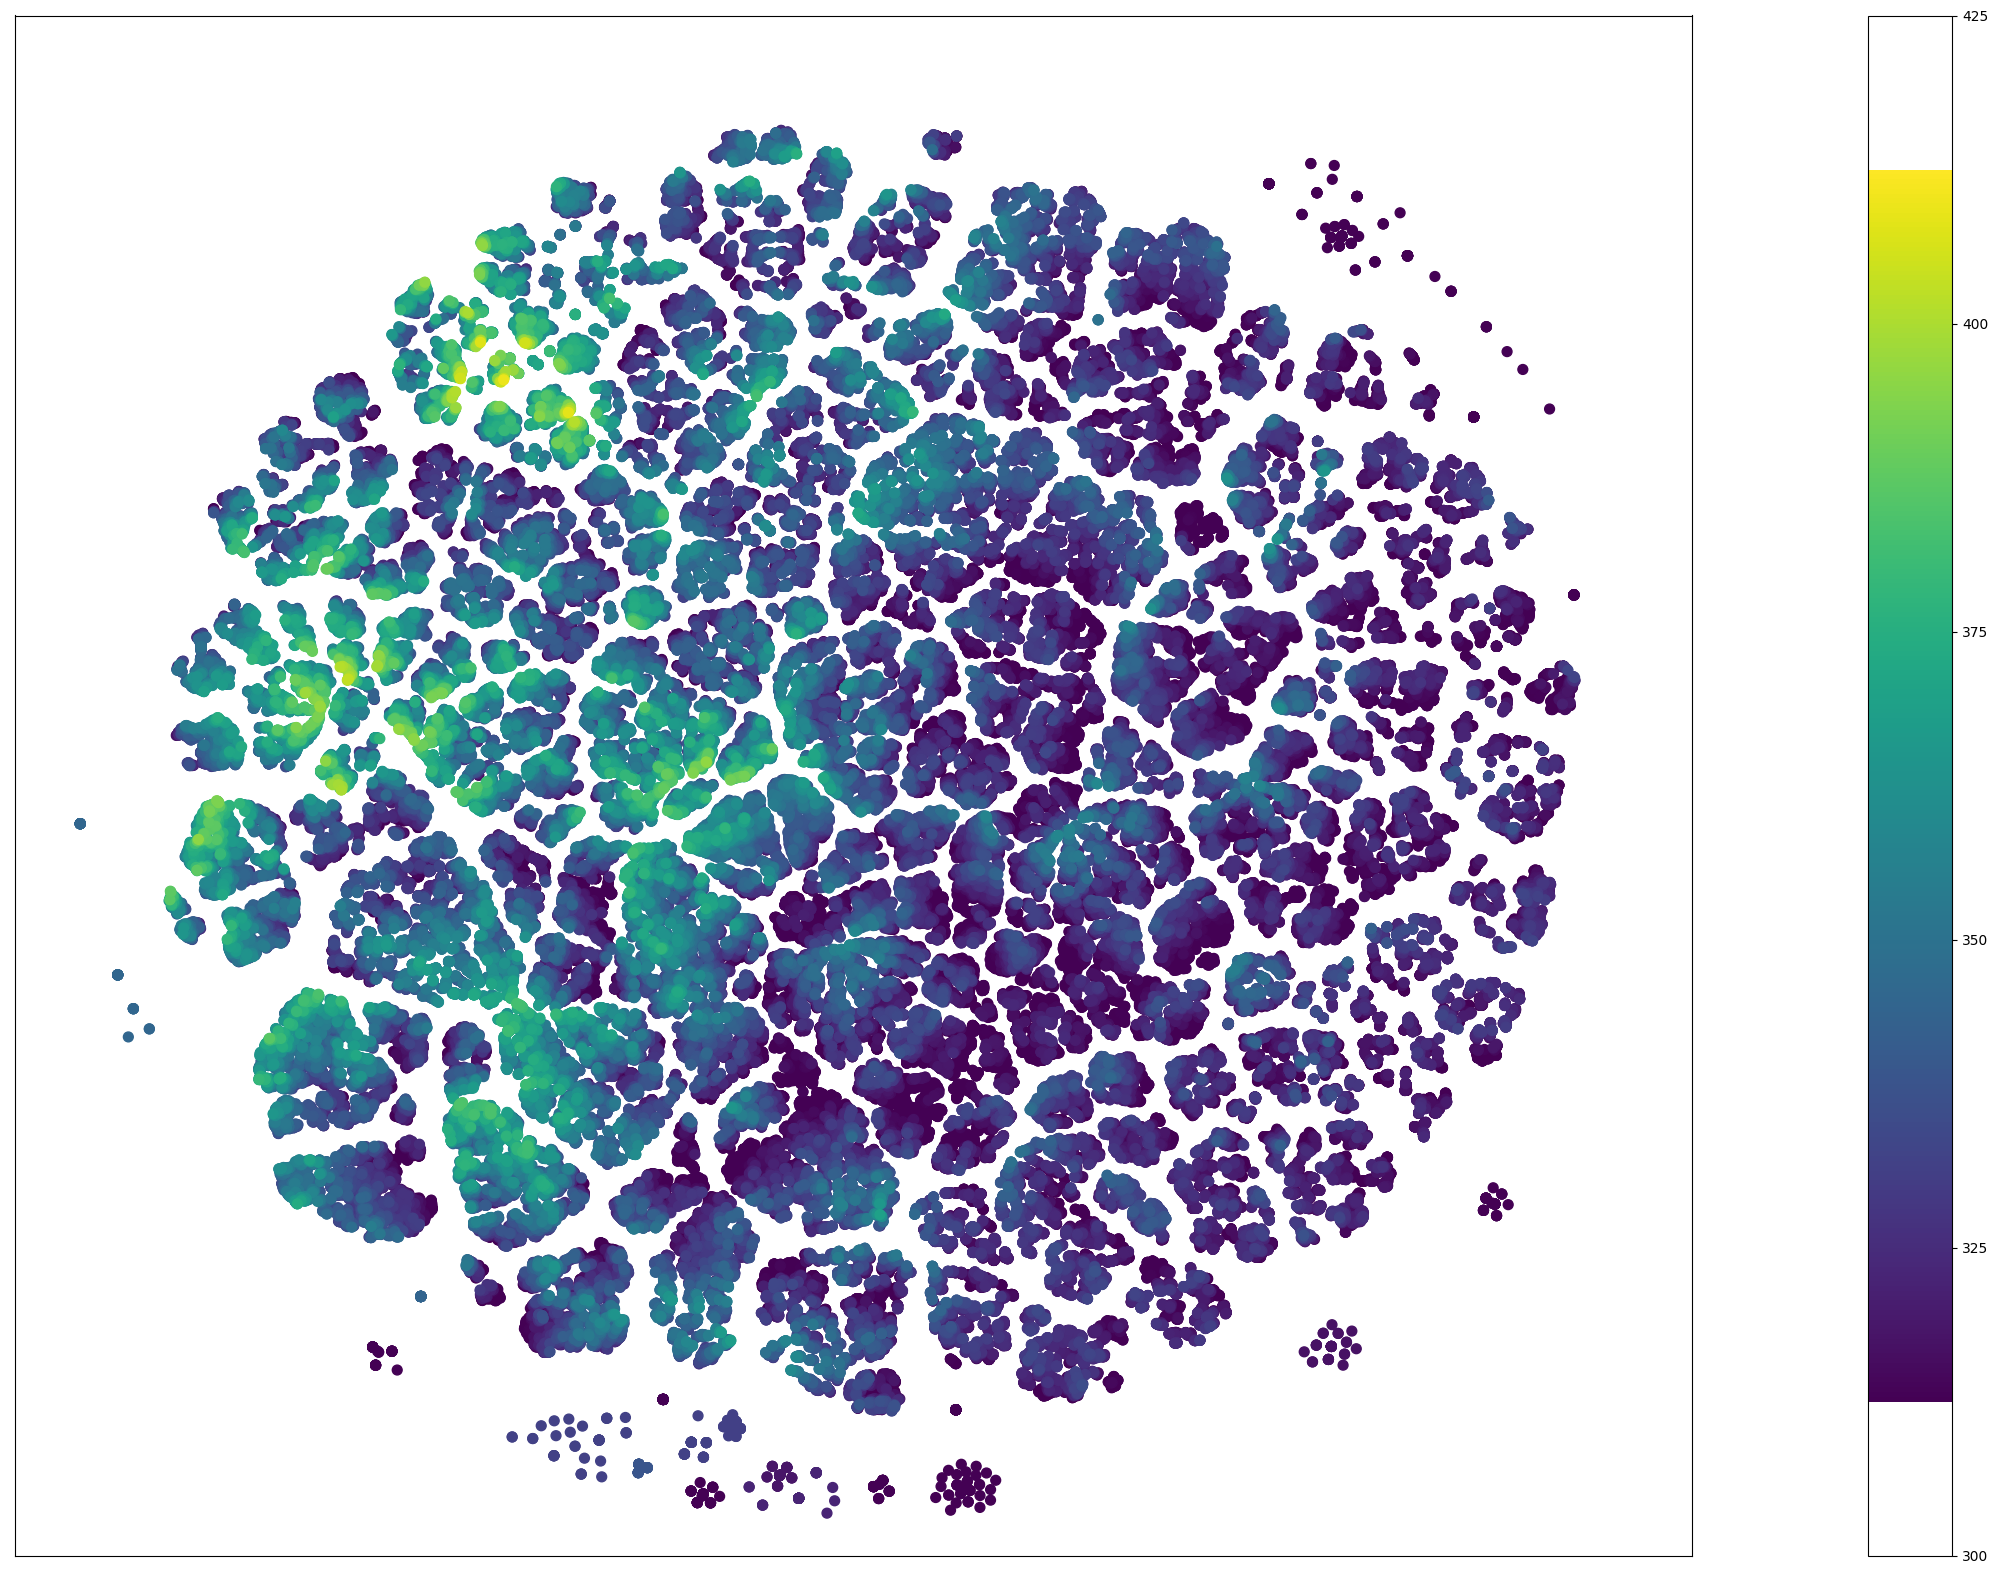

In [23]:
tval = np.mean([preds[i]['screen'].squeeze() for i in range(5)], 0) + 273.15
f, axs = plt.subplots(1,2,figsize=(25, 20), gridspec_kw={'width_ratios':[1, 0.05]})
axs[0].set_xticks([])
axs[0].set_yticks([])
otvec = tvecs['a'][:n2]
stvec = tvecs['a'][n2:]
#axs[0].scatter(*otvec[:n1].T, s=150, marker='D', edgecolor=[0,0,0], zorder=88, color=mpl.cm.tab10(5))
#axs[0].scatter(*otvec[n1:].T, s=150, marker='s', edgecolor=[0,0,0], zorder=88, color=mpl.cm.tab10(1))
#im = axs[0].scatter(*stvec[np.argsort(tval)][-200:].T, c=tval[np.argsort(tval)][-200:], s=10, cmap=mpl.cm.magma, vmin=300, vmax=500)
im = axs[0].scatter(*stvec[np.argsort(tval)].T, c=tval[np.argsort(tval)], s=50, cmap=mpl.cm.viridis, vmin=312.5, vmax=412.5)
plt.colorbar(im, cax=axs[1])
axs[1].set_yticks([300+25*i for i in range(6)])
#f.savefig('output.screen.manifold.pdf')
axs[0].set_xlim([-150,150])
axs[0].set_ylim([-150,150])
#f.savefig('./figs/output.manifold.screen.png')
#f.savefig('./figs/output.manifold.data.pdf')

(380.0, 440.0)

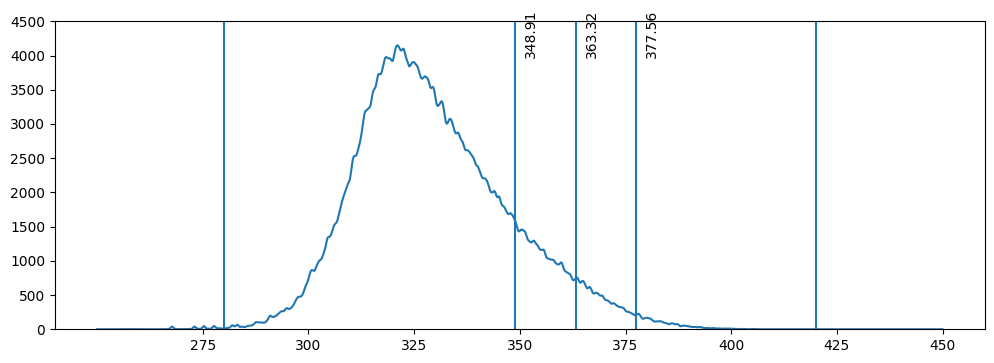

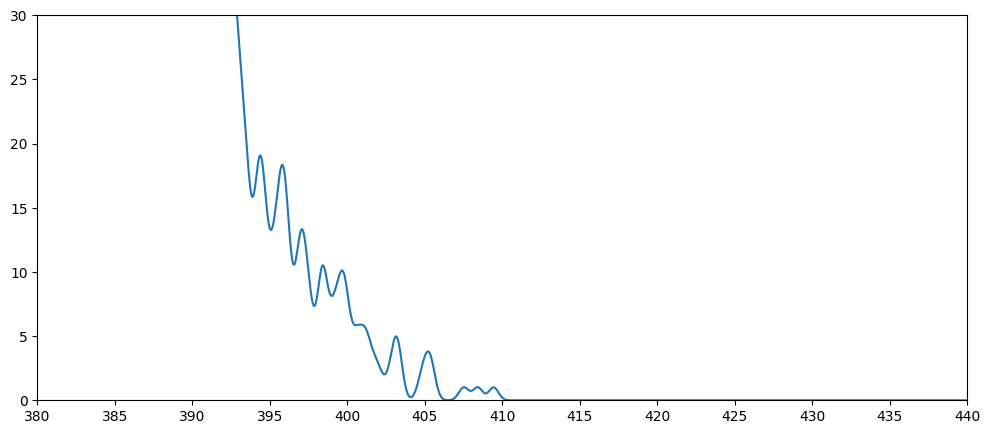

In [25]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

tval = np.mean([preds[i]['screen'] for i in range(5)], 0) + 273.15
g1 = gaussian_kernel(tval, 0.2)

f, ax = plt.subplots(1,1,figsize=(12, 4))
x = np.linspace(250, 450, 5000)
y = g1(x)
y[y < 1e-3] = 0
_ = ax.plot(x, y)

for v in np.quantile(tval, [0.85, 0.95, 0.99]):
    ax.axvline(v)
    ax.text(v+2, 4000, f'{v:.2f}', rotation=90)
ax.set_xticks([275 + 25*i for i in range(8)])
ax.axvline(280)
ax.axvline(420)
ax.set_ylim([0,4500])
#f.savefig('./figs/output.screen.distribution.pdf')

f, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(x,y)
ax.set_xticks([375 + 5*i for i in range(15)])
ax.set_ylim([0,30])
ax.set_xlim([380, 440])
#f.savefig('./figs/output.screen.distribution.inset.pdf')

In [ ]:
result_df = sdf.copy()
result_df['TG'] = tval
result_df.to_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/screen_full_results.231109.csv', index=False)

## results analysis

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from rdkit import Chem
from rdkit.Chem import Descriptors

col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']

df_screen = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/screen_full_results.231109.csv').fillna('')
df_train = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv')
df_test = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv')
df_train.TG = df_train.TG + 273.15
for i, row in df_train.iterrows():
    df_train.loc[i, col_w] = row[col_w].values / row[col_w].sum()
    ss = row[col_s]
    ss.values[row[col_w] == 0] = ''
    df_train.loc[i, col_s] = ss
smiles = sorted(np.unique(df_screen[col_s].values.reshape(-1)))
mol_ws = {s:Descriptors.MolWt(Chem.MolFromSmiles(s)) for s in smiles}

In [66]:
ssf_380, csf_380 = np.unique(df_screen[df_screen.TG > 380].SMILES_A, return_counts=True)
o = np.argsort(csf_380)[::-1]
ssf_380, csf_380 = ssf_380[o], csf_380[o]
ssf_390, csf_390 = np.unique(df_screen[df_screen.TG > 390].SMILES_A, return_counts=True)
o = np.argsort(csf_390)[::-1]
ssf_390, csf_390 = ssf_390[o], csf_390[o]
ssf_400, csf_400 = np.unique(df_screen[df_screen.TG > 400].SMILES_A, return_counts=True)
o = np.argsort(csf_400)[::-1]
ssf_400, csf_400 = ssf_400[o], csf_400[o]

In [70]:
ss_390, cs_390 = np.unique(df_screen.loc[df_screen.TG > 390, col_s].values.reshape(-1), return_counts=True)
o = np.argsort(cs_390)[::-1]
ss_390, cs_390 = ss_390[o], cs_390[o]

In [68]:
(df_screen.TG > 390).sum(), df_screen.shape

(274, (201850, 12))

In [75]:
for s, c in zip(ss_390, cs_390):
#    if 'F' in s: continue
    if 'F' not in s: continue
    if s == '': continue
    m_sta = (df_train[col_s].values == s).sum(1) != 0
#    if np.sum(m_sea) + np.sum(m_sta) != 0:
    print(c, '  /  ', s)
    v2 = df_train.loc[m_sta, 'TG'].values
    if m_sta.sum() == 0:
        print('train :   0')
    else:
        print('train : {:3d} / {:8.3f} / {:8.3f} / {:8.3f} / {:8.3f}'.format(m_sta.sum(), v2.min(), v2.max(), v2.mean(), v2.std()))
        print('  '.join([f'{v:.2f}' for v in sorted(v2)]))
    print('-'*50)
    

107   /   C=C(C(=O)O)C(F)(F)F
train :   0
--------------------------------------------------
57   /   CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F
train :  12 /  306.550 /  415.580 /  349.938 /   35.007
306.55  309.65  315.95  316.35  332.29  349.63  351.13  354.14  360.79  380.43  406.77  415.58
--------------------------------------------------
34   /   CC(=C)C(=O)OCC(F)(F)F
train :   7 /  305.050 /  361.180 /  347.089 /   17.942
305.05  345.34  347.94  354.64  357.55  357.92  361.18
--------------------------------------------------
27   /   CC(=C)C(=O)OCC(C(F)(F)F)(F)F
train :  50 /  310.050 /  405.550 /  355.894 /   23.742
310.05  315.04  315.70  318.77  318.80  320.16  327.63  330.50  331.91  333.46  336.48  336.80  339.19  340.35  341.88  342.73  342.96  344.59  345.06  348.08  348.59  350.81  350.83  351.45  353.05  354.14  357.90  357.92  359.81  366.08  367.10  369.63  372.03  372.69  373.61  373.65  373.67  373.99  375.42  376.36  376.50  376.85  380.58  380.66  383.37  384.69  393.66  3

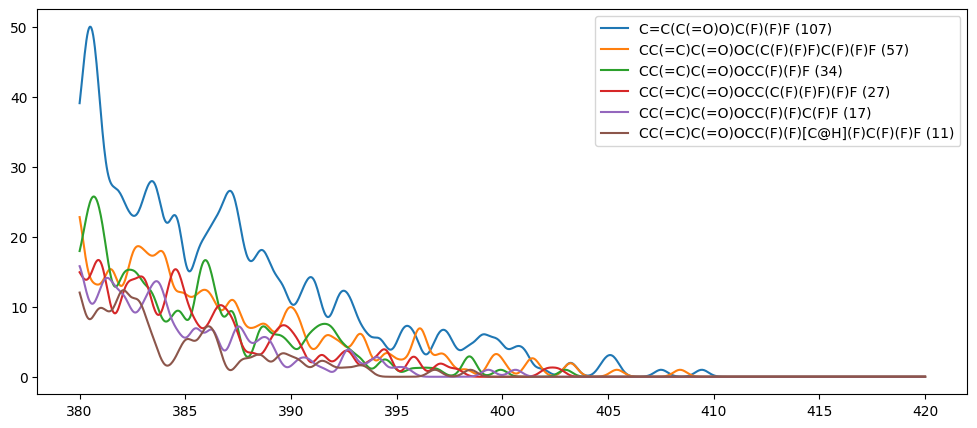

In [244]:
class gaussian_kernel:
    def __init__(self, data, sigma=0.1):
        self._d = np.array(data).reshape(-1)
        self._s = sigma
        
    def __call__(self, x):
        y = np.exp(-np.square(self._d - np.array(x.reshape(-1,1))) / self._s)
        return np.sum(y, axis=1)

f, ax = plt.subplots(1,1,figsize=(12, 5))
for s, c in zip(ss_390, cs_390):
    if 'F' not in s : continue
    if c < 10: break
    val = df_screen.TG.values[(df_screen[col_s] == s).values.sum(1) != 0]
    g1 = gaussian_kernel(val, 0.2)
    x = np.linspace(380, 420, 1000)
    y = g1(x)
    y[y < 1e-3] = 0
    ax.plot(x, y, label=f'{s} ({c})')
ax.legend(loc='upper right')

In [4]:
train_list = {make_key(r):None for i,r in df3.iterrows()}
test_list = {make_key(r):None for i,r in df4.iterrows()}
exp_list = {make_key(r):None for i,r in df1_part.iterrows()}

In [10]:
df1_part = df1.iloc[32:53].copy()
df1_part.loc[:,'S_A'] = [''] * df1_part.shape[0]

In [5]:
train_list = {}
for i,r in df3.iterrows():
    k = make_key(r)
    if k in train_list:
        train_list[k].append(i)
        print(i, k, train_list[k])
    else:
        train_list[k] = [i]


97 c10:0.20_c15:0.20_c20:0.10_c34:0.30_f04:0.19 [96, 97]
170 c05:0.40_c15:0.20_c34:0.40 [164, 170]
232 c00:0.10_c15:0.20_c34:0.40_f17:0.30 [230, 232]


In [11]:
df3.loc[[96, 97, 164, 170, 230, 232]]

ID                  Name       CAS_A       CAS_B    CAS_C  \
96   FA-00277  0184_HxFIPMA-AMMA-t2   3063-94-3  16887-36-8  80-62-6   
97   FA-00278  0185_HxFIPMA-AMMA-t3   3063-94-3  16887-36-8  80-62-6   
164  FA-00372          174_PHEA-442  45115-53-5  48145-04-6  80-62-6   
170  FA-00380         182_EGPEA-442  45115-53-5  48145-04-6  80-62-6   
230  FA-00465     314_NFA3-MMA4-AA1  52591-27-2  32360-05-7  80-62-6   
232  FA-00467      316_PF3-MMA4-AA1  52591-27-2  32360-05-7  80-62-6   

          CAS_D     CAS_E                                  SMILES_A  \
96      79-41-4  868-77-9           CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F   
97      79-41-4  868-77-9           CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F   
164     79-41-4  868-77-9              CC(=C)C(=O)OCC(C(F)(F)F)(F)F   
170     79-41-4  868-77-9              CC(=C)C(=O)OCC(C(F)(F)F)(F)F   
230  1979-10-07  868-77-9  FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C   
232  1979-10-07  868-77-9  FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C   

                             SMILES_B       SMILES_C  ...  FR_A  FR_B  FR_C  \
96   CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2  COC(=O)C(C)=C  ...  19.0  20.2  30.4   
97   CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2  COC(=O)C(C)=C  ...  19.0  20.2  30.4   
164              C=CC(=O)OCCOc1ccccc1  COC(=O)C(C)=C  ...   NaN   4.0   4.0   
170              C=CC(=O)OCCOc1ccccc1  COC(=O)C(C)=C  ...   NaN   4.0   4.0   
230    CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C  COC(=O)C(C)=C  ...   3.0   0.0   4.0   
232    CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C  COC(=O)C(C)=C  ...   3.0   0.0   4.0   

     FR_D  FR_E  ES    DC      TG       MW  TGA_0.01  
96   10.1  20.2 NaN  1.33  142.43  62292.0    187.82  
97   10.1  20.2 NaN  1.97  117.12  68858.0    181.75  
164   NaN   2.0 NaN  1.95   44.35  53116.0    267.92  
170   NaN   2.0 NaN  1.85   33.70  94960.0    226.05  
230   1.0   2.0 NaN  3.34   65.22  37302.0    253.19  
232   1.0   2.0 NaN  2.90   84.70  30523.0    181.64  

[6 rows x 22 columns]

In [9]:
for i, ri in df3.iterrows():
    ki = make_key(ri)
    for j, rj in df4.iterrows():
        kj = make_key(rj)
        if ki == kj:
            print(ki, i, j)

c15:0.20_c34:0.40_f05:0.20_f14:0.20 236 45


In [14]:
pd.concat([df3.iloc[236].to_frame().T, df4.iloc[45].to_frame().T]).T

236  \
ID                                           FA-00475   
Name                                0233_Duo_PF-NFHMA   
CAS_A                                      45115-53-5   
CAS_B                                       1799-84-4   
CAS_C                                         80-62-6   
CAS_D                                         79-41-4   
CAS_E                                        868-77-9   
SMILES_A                 CC(=C)C(=O)OCC(C(F)(F)F)(F)F   
SMILES_B  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F   
SMILES_C                                COC(=O)C(C)=C   
SMILES_D                                 CC(=C)C(O)=O   
SMILES_E                              CC(=C)C(=O)OCCO   
FR_A                                              2.0   
FR_B                                              2.0   
FR_C                                              4.0   
FR_D                                              0.0   
FR_E                                              2.0   
ES                                                NaN   
DC                                               2.14   
TG                                              54.48   
MW                                            50266.0   
TGA_0.01                                        227.6   

                                                  45   
ID                                           FA-00476  
Name                                0234_Duo_PF-NFHMA  
CAS_A                                      45115-53-5  
CAS_B                                       1799-84-4  
CAS_C                                         80-62-6  
CAS_D                                         79-41-4  
CAS_E                                        868-77-9  
SMILES_A                 CC(=C)C(=O)OCC(C(F)(F)F)(F)F  
SMILES_B  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F  
SMILES_C                                COC(=O)C(C)=C  
SMILES_D                                 CC(=C)C(O)=O  
SMILES_E                              CC(=C)C(=O)OCCO  
FR_A                                              2.0  
FR_B                                              2.0  
FR_C                                              4.0  
FR_D                                              0.0  
FR_E                                              2.0  
ES                                                NaN  
DC                                               2.02  
TG                                              71.91  
MW                                            52286.0  
TGA_0.01                                       196.11

In [394]:
for x in 'ABCDE':
    df1_part.loc[:,f'S_{x}'] = df1_part[f'SMILES_{x}'].fillna('').map(lambda a: mapper[a])
    df2.loc[:,f'S_{x}'] = df2[f'SMILES_{x}'].fillna('').map(lambda a: mapper[a])

# Experimental validation

In [213]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils.visualization import plot_scatter

In [264]:
df_exp = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymer_20231215_exp_all.csv', header=[1])
for i, m in zip(df_exp.ID_screen, df_exp.ID_screen.isna()):
    if m:
        print()
    else:
        print(df_screen.loc[i, 'TG'] - 273.15)


56.87626342773444
41.1431945800781
46.98964920043943
50.0740966796875
51.11922683715818
48.65049057006837

52.794744110107445
51.68767089843749
42.32845687866211
48.464567565917946
42.44622650146482
48.890612030029274
35.66316452026365
44.273863983154286

44.625907135009754
41.67415390014651
42.74537506103513
20.053049468994118
38.64845809936526
17.70743179321289
2.1143295288085824
10.014868927001942
49.275756072998036
43.85763778686521
34.007891845703114
44.96062469482422
-24.65716094970702
-0.13337936401364914
72.07881317138674
51.63130416870115
73.40303192138674
116.88217773437498
111.43646392822268
124.03750915527343
83.68279266357422
109.86066589355471
122.3310485839844
115.59709625244142
123.74714050292971
68.66097106933591
82.78351364135744
77.15183715820314
80.36475906372073
92.6889999389648
81.6216110229492
77.7143440246582
76.77319488525393
72.27070312500001
81.31108016967772
81.6061050415039
105.58349761962893



86.42067871093752
106.29113311767577
71.79490051269534
49.5299

In [208]:
df_exp = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymer_20231215_exp.csv')
df_screen = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/screen_full_results.231109.csv')
col_sm = [f'SMILES_{x}' for x in 'ABCDE']
col_fr = [f'FR_{x}' for x in 'ABCDE']
df = df_screen[col_sm + col_fr].copy()
df['TG_exp'] = df_exp.TG.values + 273.15
df['TG_pred'] = df_screen.iloc[df_exp.ID_screen.values.astype(int)].TG.values

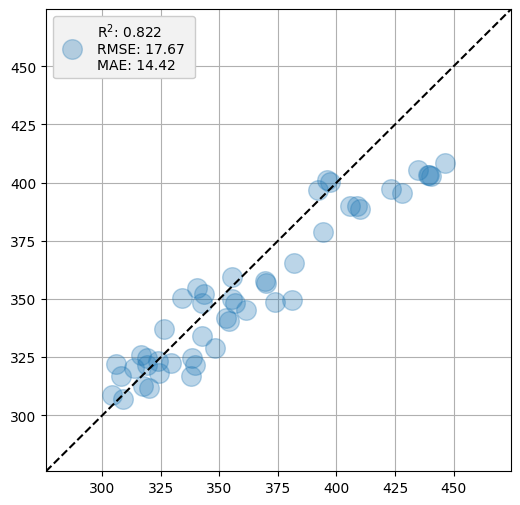

In [223]:
f, ax = plt.subplots(1,1,figsize=(6,6))
plot_scatter(ax, df.TG_exp.values, df.TG_pred.values, s=200, alpha=0.3)
#ax.set_xlim([300,450])
#ax.set_ylim([300,450])
#ax.set_xticks([300+50*i for i in range(4)])
#ax.set_yticks([300+50*i for i in range(4)])

In [229]:
df[df.TG_pred > 375].sort_values('TG_pred')

SMILES_A                          SMILES_B  \
20     FC(F)(F)C(OC(=O)C=C)C(F)(F)F      CC(=C)C(=O)OC1CC2CC1C3C2CCC3   
13            CC(=C)C(=O)OCC(F)(F)F                                     
41            CC(=C)C(=O)OCC(F)(F)F       O=C1N(OC(=O)C(=C)C)C(=O)CC1   
9   CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F                                     
12        CC(=C)C(=O)OCC(F)(F)C(F)F    CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C   
14            CC(=C)C(=O)OCC(F)(F)F    CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C   
10     CC(=C)C(=O)OCC(C(F)(F)F)(F)F    CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C   
47  CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2   
46  CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2   
42            CC(=C)C(=O)OCC(F)(F)F  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2   
45  CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2   
44  CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2   
43  CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F                     CC(=C)C(=O)NC   
40  CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2   

                            SMILES_C                     SMILES_D  \
20    CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
13    CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
41                      CC(=C)C(O)=O                                
9     CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
12                      CC(=C)C(O)=O  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
14                      CC(=C)C(O)=O  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
10                      CC(=C)C(O)=O  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
47                      CC(=C)C(O)=O                                
46                      CC(=C)C(O)=O                COC(=O)C(C)=C   
42                      CC(=C)C(O)=O  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
45    CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C                 CC(=C)C(O)=O   
44      CC(=C)C(=O)OC1CC2CC1C3C2CCC3                 CC(=C)C(O)=O   
43  CC(=C)C(=O)OC12CC3CC(C1)CC(C3)C2                 CC(=C)C(O)=O   
40                      CC(=C)C(O)=O  O=C1N(OC(=O)C(=C)C)C(=O)CC1   

           SMILES_E  FR_A  FR_B  FR_C  FR_D  FR_E  TG_exp     TG_pred  
20  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  394.12  378.733498  
13  CC(=C)C(=O)OCCO   0.2   0.0   0.4   0.2   0.2  409.94  388.747096  
41  CC(=C)C(=O)OCCO   0.2   0.2   0.4   0.0   0.2  408.60  389.979556  
9   CC(=C)C(=O)OCCO   0.2   0.0   0.4   0.2   0.2  405.68  390.032178  
12  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  428.08  395.481049  
14  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  392.10  396.897141  
10  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  423.20  397.187509  
47  CC(=C)C(=O)OCCO   0.4   0.2   0.2   0.0   0.2  397.13  400.096271  
46  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  396.07  401.278238  
42  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  440.32  402.984204  
45  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  439.12  403.138853  
44  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  439.40  403.305782  
43  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  434.78  405.418906  
40  CC(=C)C(=O)OCCO   0.2   0.2   0.2   0.2   0.2  446.14  408.409668

In [245]:
df_screen.TG.max()

409.4376754760742

In [233]:
for s in np.unique(df.SMILES_A):
    m_sta = np.sum(df_train[col_s].values == s, 1) != 0
    m_ssa = np.sum((df_screen[col_s].values == s) & (df_screen.TG > 390).values.reshape(-1,1), 1) != 0
    m_sea = np.sum(df[col_s].values == s, 1) != 0
    print(s)
    for des, df_, m in zip(['train','screen','exp'], [df_train, df_screen, df], [m_sta, m_ssa, m_sea]):
        if des == 'exp':
            v = df_[m].TG_exp.values
        else:
            v = df_[m].TG.values
        if np.sum(m) == 0:
            print('{:6s} : 0'.format(des))
        else:
            print('{:6s} : {:3d} / {:8.3f} / {:8.3f} / {:8.3f} / {:8.3f}'.format(
                des, np.sum(m), np.min(v), np.max(v), np.mean(v), np.std(v)
            ))
        if (np.sum(m) < 20) & (np.sum(m) > 0):
            print('\t','  '.join([f'{v:.2f}' for v in sorted(v)]))
    if (np.sum(m) < 20) & (np.sum(m) > 0):
        v = df_[m].TG_pred.values
        print('\t','  '.join([f'{v:.2f}' for v in sorted(v)]))
    print('-'*50)
    

C=C(C(=O)O)C(F)(F)F
train  : 0
screen : 107 /  390.182 /  409.438 /  395.467 /    4.341
exp    :   1 /  355.600 /  355.600 /  355.600 /    0.000
	 355.60
	 359.57
--------------------------------------------------
CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F
train  :  12 /  306.550 /  415.580 /  349.938 /   35.007
	 306.55  309.65  315.95  316.35  332.29  349.63  351.13  354.14  360.79  380.43  406.77  415.58
screen :  57 /  390.032 /  408.410 /  395.127 /    4.215
exp    :   9 /  348.290 /  446.140 /  408.437 /   32.407
	 348.29  369.32  396.07  397.13  405.68  434.78  439.12  439.40  446.14
	 329.03  357.72  390.03  400.10  401.28  403.14  403.31  405.42  408.41
--------------------------------------------------
CC(=C)C(=O)OCC(C(F)(F)F)(F)F
train  :  50 /  310.050 /  405.550 /  355.894 /   23.742
screen :  27 /  390.014 /  402.653 /  394.002 /    3.234
exp    :   1 /  423.200 /  423.200 /  423.200 /    0.000
	 423.20
	 397.19
--------------------------------------------------
CC(=C)C(=O)OCC(F)(F)

In [136]:
df_screen.loc[[screen_keys.index(k) for k in exp_keys[70:80]], col_sm + col_fr].T

98914   \
SMILES_A                  CC(=C)C(=O)OCC(F)(F)F   
SMILES_B  CC1C2CC(C1(C)C)CC2C3CCCC(C3)OC(=O)C=C   
SMILES_C                                          
SMILES_D                                          
SMILES_E                        CC(=C)C(=O)OCCO   
FR_A                                        0.2   
FR_B                                        0.6   
FR_C                                        0.0   
FR_D                                        0.0   
FR_E                                        0.2   

                                        109015  \
SMILES_A  CC(=C)C(=O)OCC(F)(F)[C@H](F)C(F)(F)F   
SMILES_B           CCCCCCCCCCCCCCCCCCOC(=O)C=C   
SMILES_C                     C=CC(=O)OCC1CCCO1   
SMILES_D                                         
SMILES_E                       CC(=C)C(=O)OCCO   
FR_A                                       0.2   
FR_B                                       0.2   
FR_C                                       0.4   
FR_D                                       0.0   
FR_E                                       0.2   

                                                     123565  \
SMILES_A  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...   
SMILES_B                               CC(=C)C(=O)OC(C)(C)C   
SMILES_C                               CC(=C)C(=O)OC1CCCCC1   
SMILES_D                               CC(=C)C(=O)OCc1occc1   
SMILES_E                                    CC(=C)C(=O)OCCO   
FR_A                                                    0.2   
FR_B                                                    0.2   
FR_C                                                    0.2   
FR_D                                                    0.2   
FR_E                                                    0.2   

                                                     126439  \
SMILES_A  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...   
SMILES_B              CC1C2CC(C1(C)C)CC2C3CCCC(C3)OC(=O)C=C   
SMILES_C                                                      
SMILES_D                                                      
SMILES_E                                    CC(=C)C(=O)OCCO   
FR_A                                                    0.2   
FR_B                                                    0.6   
FR_C                                                    0.0   
FR_D                                                    0.0   
FR_E                                                    0.2   

                                                     127245  \
SMILES_A  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...   
SMILES_B               CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C   
SMILES_C                              CCCCC(CC)COC(=O)C=C     
SMILES_D                                                      
SMILES_E                                    CC(=C)C(=O)OCCO   
FR_A                                                    0.2   
FR_B                                                    0.2   
FR_C                                                    0.4   
FR_D                                                    0.0   
FR_E                                                    0.2   

                                                     127747  \
SMILES_A  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...   
SMILES_B                        O=C1N(OC(=O)C(=C)C)C(=O)CC1   
SMILES_C                                                      
SMILES_D                                                      
SMILES_E                                    CC(=C)C(=O)OCCO   
FR_A                                                    0.4   
FR_B                                                    0.4   
FR_C                                                    0.0   
FR_D                                                    0.0   
FR_E                                                    0.2   

                                                     127989  \
SMILES_A  CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...   
SMILES_B                  

In [ ]:
with open('/home/jhyang/WORKSPACES/fpoly_preds_exp_231109.pkl','rb') as f:
    preds_exp = pickle.load(f)
pval = np.mean([preds_exp['exp']['finetune'][i][1] for i in range(5)], 0)
df_exp = pd.read_csv('./data/fpolymers_230808_high_tg_exp.csv')
df_exp = df_exp[~df_exp.TG.isna()]
df_exp.TG = df_exp.TG + 273.15
df_exp['TG_pred'] = pval + 273.15
df_exp = df_exp.reset_index(drop=True)
df_exp[col_w].fillna(0)
for i, row in df_exp.iterrows():
    df_exp.loc[i, col_w] = row[col_w].fillna(0) / row[col_w].fillna(0).sum()
    ss = row[col_s]
    ss.values[df_exp.loc[i, col_w] == 0] = ''
    df_exp.loc[i, col_s] = ss
df_exph = df_exp[df_exp.TG > 380].copy()


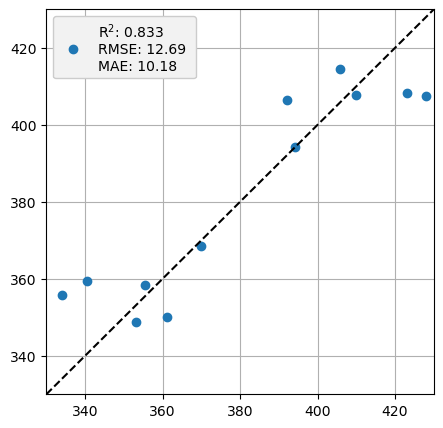

In [439]:

m = ~df1_part.TG.isna()
f, ax = plt.subplots(1,1,figsize=(5,5))
plot_scatter(ax, df1_part.TG[m]+273.15, tval[list(final.values())][m], xrange=[330,430])

In [15]:
ret

<Response [500]>

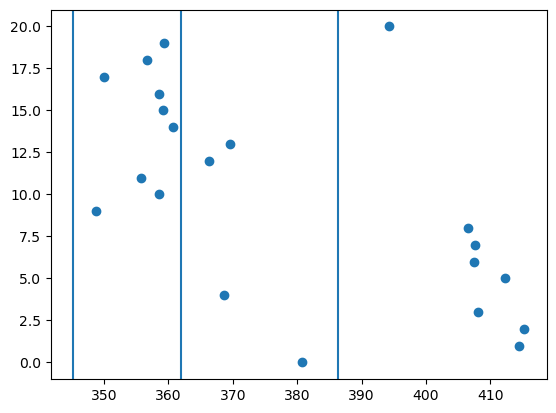

In [447]:
pvals = tval[list(final.values())]
percentiles = np.percentile(tval, [75, 90, 99])
_ = plt.scatter(pvals, np.arange(len(final)))
for v in percentiles:
    plt.axvline(v)

In [599]:
tgt1 = set(np.array(list(final.values()))[pvals > percentiles[-1]])
tgt2 = set(np.array(list(final.values()))[pvals < percentiles[-1]])
tgt1, tgt2

({48636, 55026, 58516, 94546, 98036, 104426, 107916, 202794},
 {15548,
  64461,
  158981,
  159516,
  159542,
  159566,
  162926,
  162938,
  163251,
  163262,
  168861,
  169422,
  173142})

- plot manifold with distance

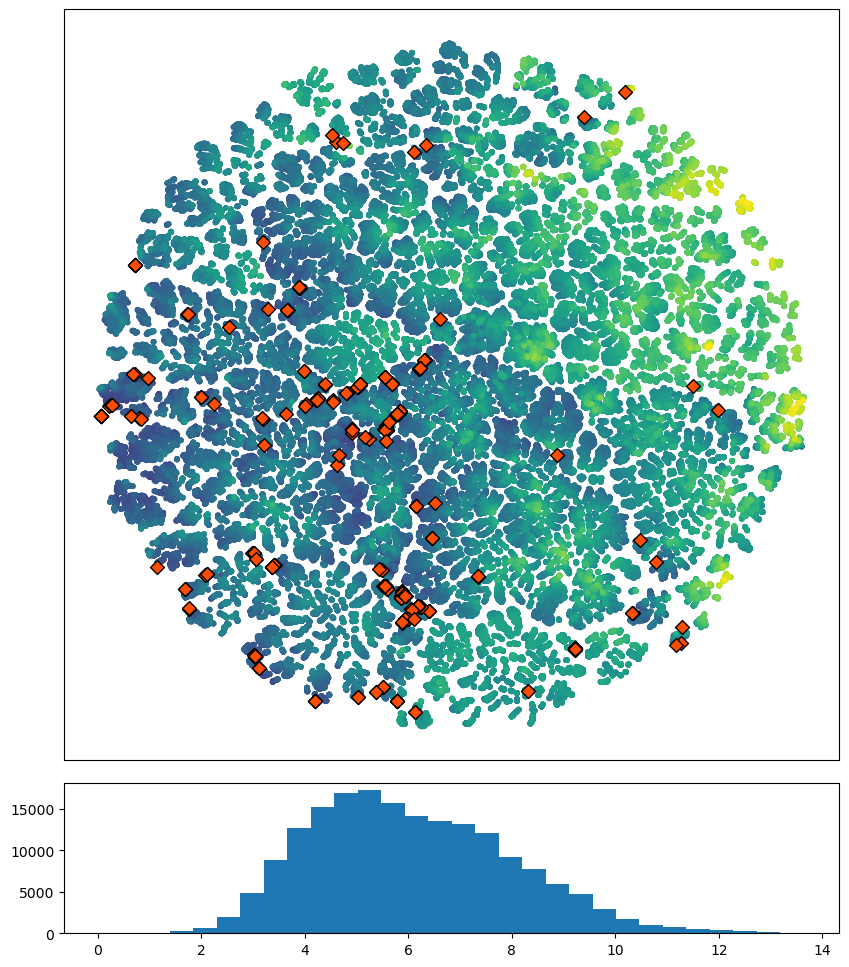

In [26]:
f, axs = plt.subplots(2,1,figsize=(10, 12), gridspec_kw={'height_ratios':[1, 0.2]})

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].scatter(*stvec[np.argsort(dists0)].T, c=dists0[np.argsort(dists0)], s=10)
axs[0].scatter(*otvec.T, color=[1, 0.3, 0], s=50, marker='D', edgecolor=[0,0,0])

axs[1].hist(dists0, bins=30)
f.subplots_adjust(hspace=0.05)

- using minimum

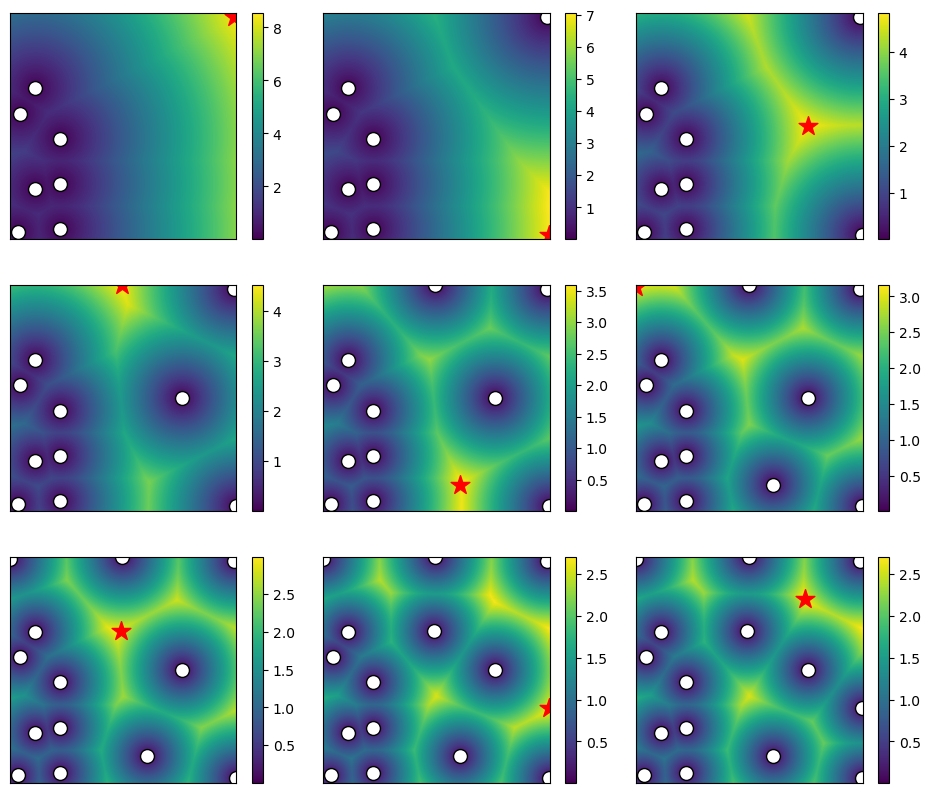

In [269]:
x, y = np.random.rand(2, 2000) * 9
o0 = np.array([[0.3,0.3],[2,0.4], [1,6], [2,2.2], [2,4], [0.4,5], [1,2]])
s0 = np.vstack([x.reshape(-1), y.reshape(-1)]).T
x, y = np.meshgrid(np.linspace(0,9,500),np.linspace(0,9,500))
grid = np.vstack([x.reshape(-1), y.reshape(-1)]).T
l = np.sqrt(np.square(o0[:, np.newaxis, :] - s0).sum(-1)).min(0)
g = np.sqrt(np.square(o0[:, np.newaxis, :] - grid).sum(-1)).min(0)
f, axs = plt.subplots(3,3,figsize=(12,10))
idxs = []
for ax in axs.reshape(-1):
    im = ax.imshow(g.reshape(500,500), extent=[0,9,0,9], origin='lower')
    plt.colorbar(im)
    i = np.argmax(l)
    o0 = np.vstack([o0, s0[i]])
    l = np.sqrt(np.square(o0[:, np.newaxis, :] - s0).sum(-1)).min(0)
    g = np.sqrt(np.square(o0[:, np.newaxis, :] - grid).sum(-1)).min(0)
    ax.scatter(*o0[:-1].T, s=100, color=[1,1,1], edgecolor=[0,0,0])
    ax.scatter(*o0[-1], s=200, marker='*', color=[1,0,0])
    ax.set_xticks([])
    ax.set_yticks([])
f.subplots_adjust(wspace=0.03)

In [194]:
_ovec = ovec.copy()

c = 2000
gens = {}
for g in range(40):
    dists = []
    pbar = tqdm.tqdm(total=int(n3/c)+1, desc=f'gen: {g}')
    for i in range(0, n3, c):
        dists.append(np.sum(np.square(_ovec[:, np.newaxis, :] - svec[i:i+c]), axis=-1).min(0))
        pbar.update(1)
    dists = np.hstack(dists)
    k = np.argmax(dists)
    gens[g] = k, dists
    _ovec = np.vstack([_ovec, svec[k]])
    

gen: 39:  99%|█████████▉| 91/92 [00:22<00:00,  4.07it/s]

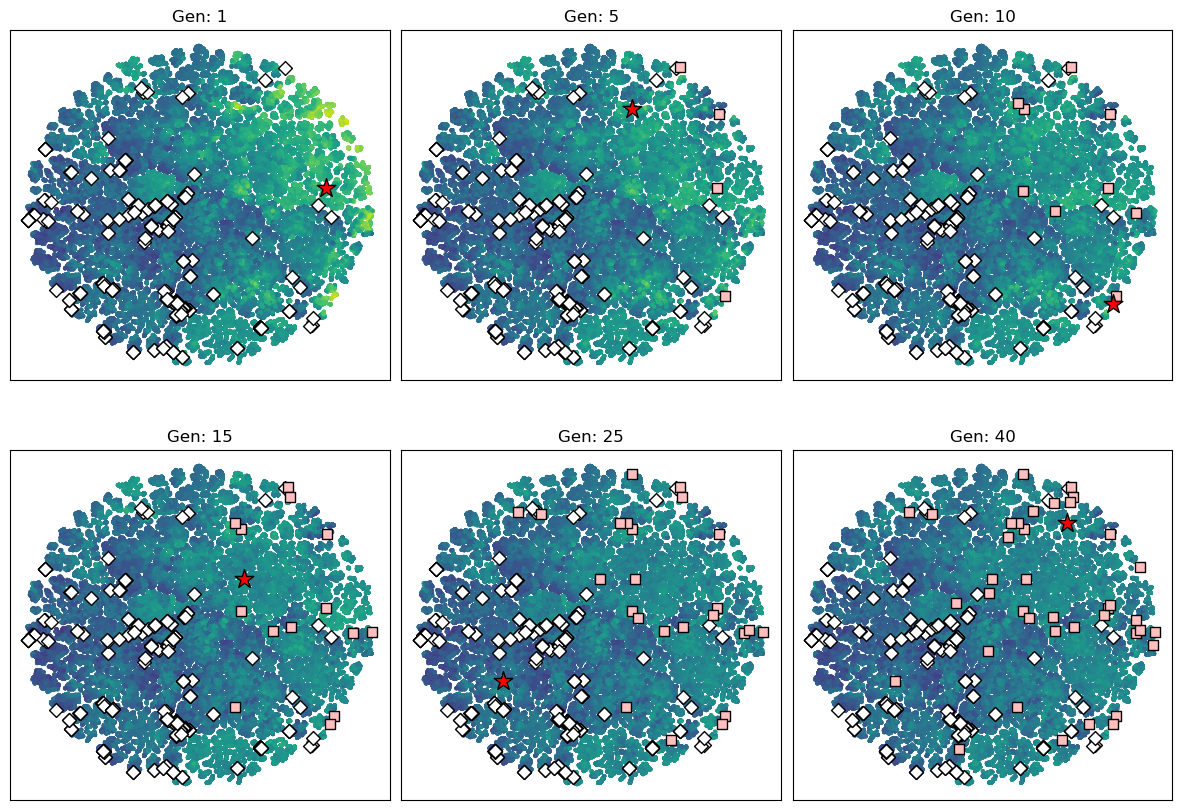

In [303]:
f, axs = plt.subplots(2,3,figsize=(15,10))
js = sorted([0, 4, 9, 14, 24, 39])
for j, ax in zip(js, axs.reshape(-1)):
    ax.set_title(f'Gen: {j+1}', fontsize=12)
    _otvec = np.vstack([otvec, stvec[[gens[n][0] for n in range(j)]]])
    i, l = gens[j]
    im = ax.scatter(*stvec[:].T, s=4, c=np.sqrt(l)[:], vmin=0, vmax=14)
    ax.scatter(*_otvec[:n2].T, s=50, color=[1,1,1], edgecolor=[0,0,0], marker='D')
    ax.scatter(*_otvec[n2:].T, s=50, color=[1,0.75,0.75], edgecolor=[0,0,0], marker='s')
    ax.scatter(*stvec[i], s=200, marker='*', color=[1,0,0], edgecolor=[0,0,0])
    ax.set_xticks([])
    ax.set_yticks([])
f.subplots_adjust(wspace=0.03)

Text(0.5, 0, 'Distance')

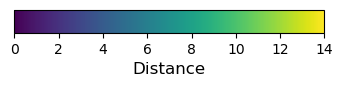

In [287]:
f, axs = plt.subplots(1,1,figsize=(4, 0.3))
plt.colorbar(im, cax=axs, orientation='horizontal')
axs.set_xlabel('Distance', fontsize=12)

Text(0.5, 0, 'Distance')

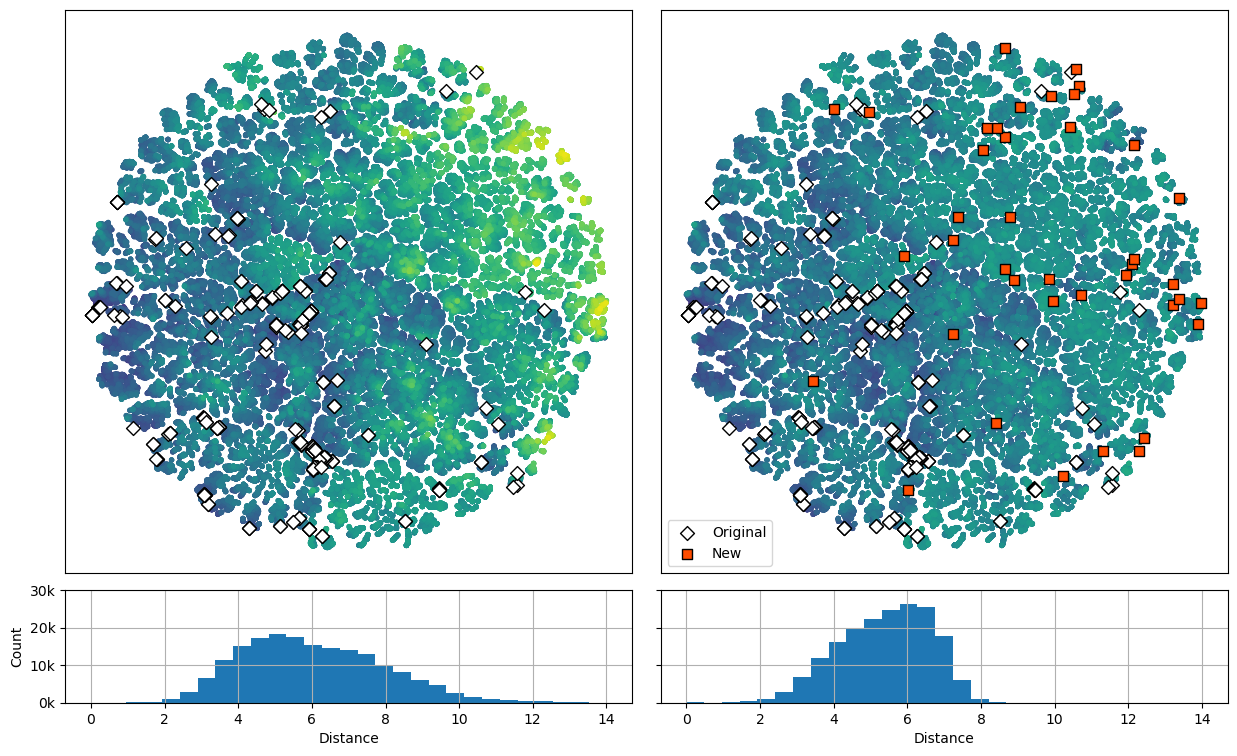

In [321]:
f, axs = plt.subplots(2,2,figsize=(15, 9), gridspec_kw={'height_ratios':[1, 0.2]})
for ax in axs[0]:
    ax.set_xticks([])
    ax.set_yticks([])
im = axs[0,0].scatter(*stvec[np.argsort(dists0)].T, c=dists0[np.argsort(dists0)], s=8, vmin=0, vmax=14)
axs[0,0].scatter(*otvec.T, color=[1, 1, 1], s=50, marker='D', edgecolor=[0,0,0])
axs[1,0].hist(dists0, bins=np.linspace(0,14,30))

idxs = [g[0] for g in gens.values()]
fin_dist = np.sqrt(gens[39][1])

im = axs[0,1].scatter(*stvec[np.argsort(fin_dist)].T, c=fin_dist[np.argsort(fin_dist)], s=8, vmin=0, vmax=14)
axs[0,1].scatter(*otvec.T, color=[1, 1, 1], s=50, marker='D', edgecolor=[0,0,0], label='Original')
axs[0,1].scatter(*stvec[idxs].T, color=[1, 0.3, 0], s=50, marker='s', edgecolor=[0,0,0], label='New')
axs[1,1].hist(fin_dist, bins=np.linspace(0,14,30))
axs[0,1].legend(loc='lower left')
f.subplots_adjust(wspace=0.05, hspace=0.05)
for ax in axs[1]: 
    ax.set_ylim([0,30000])
    ax.set_yticks([i*10000 for i in range(4)], labels=[f'{i*10}k' for i in range(4)])
    ax.grid('on')
axs[1,1].set_yticklabels([])
axs[1,0].set_ylabel('Count')
axs[1,0].set_xlabel('Distance')
axs[1,1].set_xlabel('Distance')

Text(0.5, 0, 'Distance')

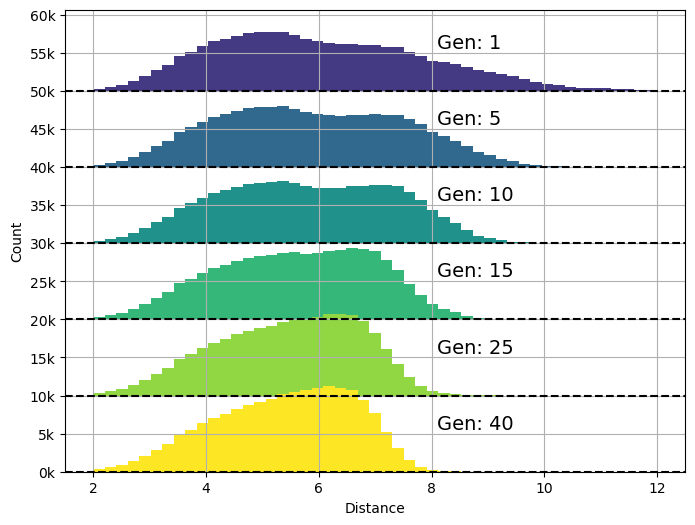

In [314]:
f, ax = plt.subplots(1,1,figsize=(8,6))
idxs = [0, 4, 9, 14, 24, 39]
ax.set_yticks([i*5000 for i in range(13)], labels=[f'{i*5}k' for i in range(13)])
for i, j in enumerate(idxs):
    _, d = gens[j]
    ax.hist(np.sqrt(d), bottom=(5-i)*10000, bins=np.linspace(2,12,50), color=mpl.cm.viridis((i+1)/6))
    ax.text(8.1, (5-i)*10000+ 5600, s=f'Gen: {j+1}', fontsize=14)
ax.grid('on')
for i in range(6): ax.axhline(i*10000, ls='--', color=[0,0,0])
ax.set_ylabel('Count')
ax.set_xlabel('Distance')

- selected data

In [259]:
df.iloc[idxs].sort_values('ID').to_csv('./screening_230621.csv', index=False)

In [332]:
mapper = {s:f'c{i}' for i,s in enumerate(smiles_c)}
mapper.update({s:f'f{i}' for i,s in enumerate(smiles_f)})
_sdf = sdf.iloc[idxs].copy().sort_values('ID')
_sdf.pop('SMILES_E')
for xx in 'BCD':
    _sdf[f'SMILES_{xx}'] = sdf[f'SMILES_{xx}'].map(lambda x: mapper[x] if x in mapper.keys() else '')
_sdf[f'SMILES_A'] = sdf[f'SMILES_A'].map(lambda x: mapper[x] if x in mapper.keys() else '')
_sdf

ID SMILES_A SMILES_B SMILES_C SMILES_D  FR_A  FR_B  FR_C  FR_D  \
4637      4637       f0      c10      c15      c23   0.2   0.2   0.2   0.2   
8682      8682       f0       c6      c22            0.4   0.2   0.2   0.0   
16288    16288       f1      c10                     0.2   0.6   0.0   0.0   
16511    16511       f1       c5      c23            0.2   0.2   0.4   0.0   
16512    16512       f1       c5      c24            0.2   0.2   0.4   0.0   
17249    17249       f1      c26      c25            0.2   0.2   0.4   0.0   
17579    17579       f1       c5                     0.4   0.4   0.0   0.0   
17654    17654       f1       c1      c11            0.4   0.2   0.2   0.0   
31988    31988       f3      c10      c12      c23   0.2   0.2   0.2   0.2   
36518    36518       f3       c2                     0.6   0.2   0.0   0.0   
72617    72617       f7       c5      c20            0.4   0.2   0.2   0.0   
72643    72643       f7       c6      c17            0.4   0.2   0.2   0.0   
73091    73091       f7      c23                     0.6   0.2   0.0   0.0   
83492    83492       f9       c2       c6       c8   0.2   0.2   0.2   0.2   
89405    89405       f9      c23                     0.2   0.6   0.0   0.0   
99468    99468      f10      c26       c2            0.2   0.2   0.4   0.0   
104460  104460      f11       c8      c12      c16   0.2   0.2   0.2   0.2   
107681  107681      f11      c23                     0.2   0.6   0.0   0.0   
108487  108487      f11      c22      c24            0.2   0.2   0.4   0.0   
108989  108989      f11      c35                     0.4   0.4   0.0   0.0   
109203  109203      f11       c6      c25            0.4   0.2   0.2   0.0   
109353  109353      f11      c12      c22            0.4   0.2   0.2   0.0   
109417  109417      f11      c15      c23            0.4   0.2   0.2   0.0   
121577  121577      f13       c5      c11      c15   0.2   0.2   0.2   0.2   
121910  121910      f13       c6       c8      c17   0.2   0.2   0.2   0.2   
122099  122099      f13       c6      c16      c26   0.2   0.2   0.2   0.2   
124074  124074      f13      c12      c22      c25   0.2   0.2   0.2   0.2   
125938  125938      f13       c4                     0.2   0.6   0.0   0.0   
125956  125956      f13      c22                     0.2   0.6   0.0   0.0   
126062  126062      f13       c2      c23            0.2   0.2   0.4   0.0   
126164  126164      f13       c5      c20            0.2   0.2   0.4   0.0   
126795  126795      f13      c23      c20            0.2   0.2   0.4   0.0   
127265  127265      f13      c35                     0.4   0.4   0.0   0.0   
127919  127919      f13      c23                     0.6   0.2   0.0   0.0   
135078  135078      f14       c6                     0.2   0.6   0.0   0.0   
135092  135092      f14      c20                     0.2   0.6   0.0   0.0   
137040  137040      f14       c6                     0.6   0.2   0.0   0.0   
165279  165279      f18       c1       c8      c26   0.2   0.2   0.2   0.2   
173592  173592      f18       c6                     0.6   0.2   0.0   0.0   
181626  181626      f19      c23      c24            0.2   0.2   0.4   0.0   

        FR_E  
4637     0.2  
8682     0.2  
16288    0.2  
16511    0.2  
16512    0.2  
17249    0.2  
17579    0.2  
17654    0.2  
31988    0.2  
36518    0.2  
72617    0.2  
72643    0.2  
73091    0.2  
83492    0.2  
89405    0.2  
99468    0.2  
104460   0.2  
107681   0.2  
108487   0.2  
108989   0.2  
109203   0.2  
109353   0.2  
109417   0.2  
121577   0.2  
121910   0.2  
122099   0.2  
124074   0.2  
125938   0.2  
125956   0.2  
126062   0.2  
126164   0.2  
126795   0.2  
127265   0.2  
127919   0.2  
135078   0.2  
135092   0.2  
137040   0.2  
165279   0.2  
173592   0.2  
181626   0.2

- check new monomer

In [340]:
si_mask = np.zeros(sdf.shape[0], dtype=bool)
for x in 'BCD':
    si_mask = si_mask | sdf[f'SMILES_{x}'].map(lambda a: 'Si' in str(a))


ID             SMILES_A  \
12          12  C=C(C(=O)O)C(F)(F)F   
45          45  C=C(C(=O)O)C(F)(F)F   
77          77  C=C(C(=O)O)C(F)(F)F   
108        108  C=C(C(=O)O)C(F)(F)F   
138        138  C=C(C(=O)O)C(F)(F)F   
...        ...                  ...   
182510  182510   FC(F)(F)COC(=O)C=C   
182511  182511   FC(F)(F)COC(=O)C=C   
182512  182512   FC(F)(F)COC(=O)C=C   
182513  182513   FC(F)(F)COC(=O)C=C   
182738  182738   FC(F)(F)COC(=O)C=C   

                                                 SMILES_B  \
12                                              C=CC(=O)O   
45                                              C=CC(=O)O   
77                                              C=CC(=O)O   
108                                             C=CC(=O)O   
138                                             C=CC(=O)O   
...                                                   ...   
182510  CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...   
182511  CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...   
182512  CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...   
182513  CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...   
182738  CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...   

                           SMILES_C  \
12       C=CC(=O)OC1C=CC2C1C3CCC2C3   
45                C=CC(=O)OCC1CCCO1   
77                   C=CC(=O)OCCC#N   
108            C=CC(=O)OCCOc1ccccc1   
138               C=CC(=O)Oc1ccccc1   
...                             ...   
182510          CN(C)CCOC(=O)C(C)=C   
182511                COC(=O)C(C)=C   
182512                   COC(=O)C=C   
182513  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
182738                          NaN   

                                                 SMILES_D         SMILES_E  \
12      CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...  CC(=C)C(=O)OCCO   
45      CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...  CC(=C)C(=O)OCCO   
77      CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...  CC(=C)C(=O)OCCO   
108     CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...  CC(=C)C(=O)OCCO   
138     CC(=C)C(=O)OCCC[Si](O[Si](C)(C)C)(O[Si](C)(C)C...  CC(=C)C(=O)OCCO   
...                                                   ...              ...   
182510                                                NaN  CC(=C)C(=O)OCCO   
182511                                                NaN  CC(=C)C(=O)OCCO   
182512                                                NaN  CC(=C)C(=O)OCCO   
182513                                                NaN  CC(=C)C(=O)OCCO   
182738                                                NaN  CC(=C)C(=O)OCCO   

        FR_A  FR_B  FR_C  FR_D  FR_E  
12       0.2   0.2   0.2   0.2   0.2  
45       0.2   0.2   0.2   0.2   0.2  
77       0.2   0.2   0.2   0.2   0.2  
108      0.2   0.2   0.2   0.2   0.2  
138      0.2   0.2   0.2   0.2   0.2  
...      ...   ...   ...   ...   ...  
182510   0.4   0.2   0.2   0.0   0.2  
182511   0.4   0.2   0.2   0.0   0.2  
182512   0.4   0.2   0.2   0.0   0.2  
182513   0.4   0.2   0.2   0.0   0.2  
182738   0.6   0.2   0.0   0.0   0.2  

[14060 rows x 11 columns]

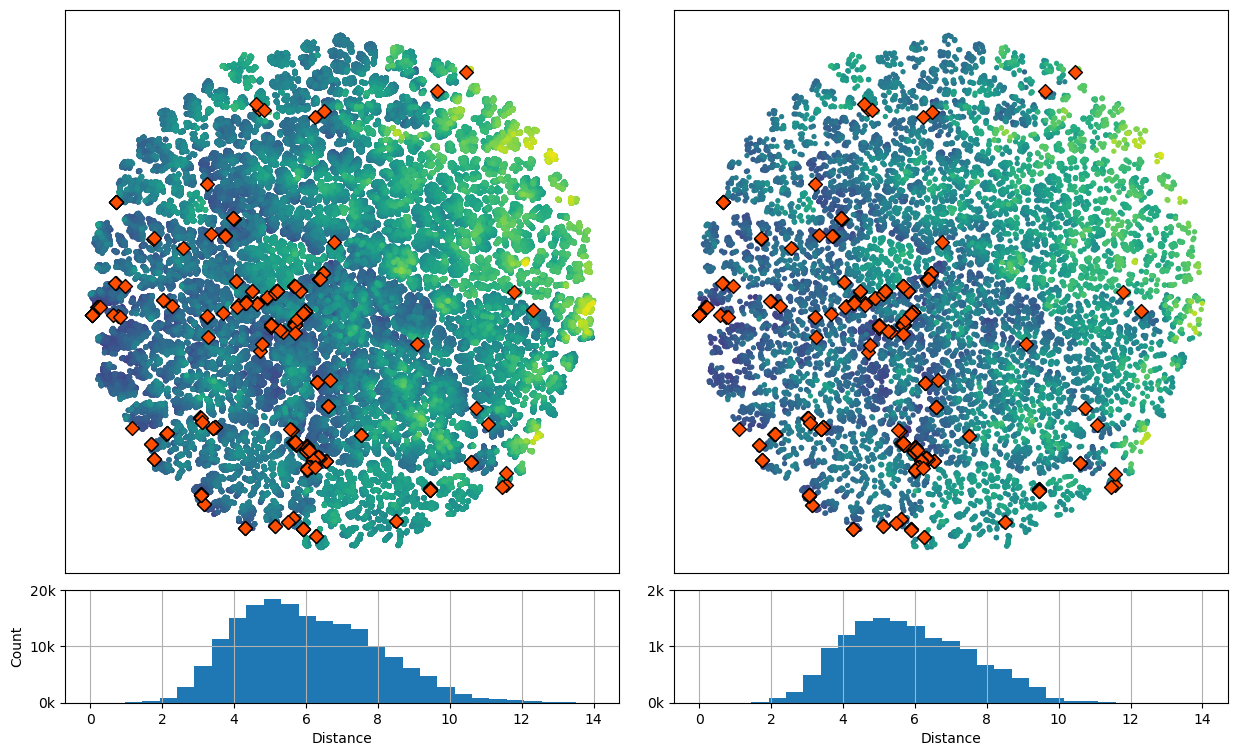

In [347]:
f, axs = plt.subplots(2,2,figsize=(15, 9), gridspec_kw={'height_ratios':[1, 0.2]})
for ax in axs[0]:
    ax.set_xticks([])
    ax.set_yticks([])
im = axs[0,0].scatter(*stvec[np.argsort(dists0)].T, c=dists0[np.argsort(dists0)], s=8, vmin=0, vmax=14)
axs[0,0].scatter(*otvec.T, color=[1, 0.3, 0], s=50, marker='D', edgecolor=[0,0,0])
axs[1,0].hist(dists0, bins=np.linspace(0,14,30))

idxs = [g[0] for g in gens.values()]
fin_dist = np.sqrt(gens[39][1])

im = axs[0,1].scatter(*stvec[np.argsort(dists0)][si_mask].T, c=dists0[np.argsort(dists0)][si_mask], s=8, vmin=0, vmax=14)
axs[0,1].scatter(*otvec.T, color=[1, 0.3, 0], s=50, marker='D', edgecolor=[0,0,0])
axs[1,1].hist(dists0[si_mask], bins=np.linspace(0,14,30))

axs[1,0].set_ylim([0,20000])
axs[1,0].set_yticks([i*10000 for i in range(3)], labels=[f'{i*10}k' for i in range(3)])
axs[1,0].grid('on')

axs[1,1].set_ylim([0,2000])
axs[1,1].set_yticks([i*1000 for i in range(3)], labels=[f'{i}k' for i in range(3)])
axs[1,1].grid('on')

axs[1,0].set_ylabel('Count')
axs[1,0].set_xlabel('Distance')
axs[1,1].set_xlabel('Distance')

f.subplots_adjust(wspace=0.1, hspace=0.05)